<a href="https://colab.research.google.com/github/garry-cotton/CS909/blob/master/2023/A1/Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [168]:
# Get files
!wget -q -O Xtrain.csv https://raw.githubusercontent.com/garry-cotton/CS909/master/2023/A1/Xtrain.csv
!wget -q -O Ytrain.csv https://raw.githubusercontent.com/garry-cotton/CS909/master/2023/A1/Ytrain.csv
!wget -q -O Xtest.csv https://raw.githubusercontent.com/garry-cotton/CS909/master/2023/A1/Xtest.csv

In [100]:
# Library imports
import numpy as np
from numpy.random import rand
import os
import matplotlib.pyplot as plt

In [188]:
# Data load
Xtrain = np.loadtxt("Xtrain.csv")
Ytrain = np.loadtxt("Ytrain.csv")
Xtest = np.loadtxt("Xtest.csv")

n_train = Xtrain.shape[0]
n_test = Xtest.shape[0]
n_positive = np.sum(Ytrain == 1)

print("Number of training examples:", n_train)
print("Number of test examples:", n_test)
print("Proportion of positive labels:", round(n_positive / n_train, 2))

Xtrain = Xtrain.reshape(n_train, 28, 28)
Xtest = Xtest.reshape(n_test, 28, 28)

Number of training examples: 3000
Number of test examples: 3000
Proportion of positive labels: 0.2


<Figure size 432x288 with 0 Axes>

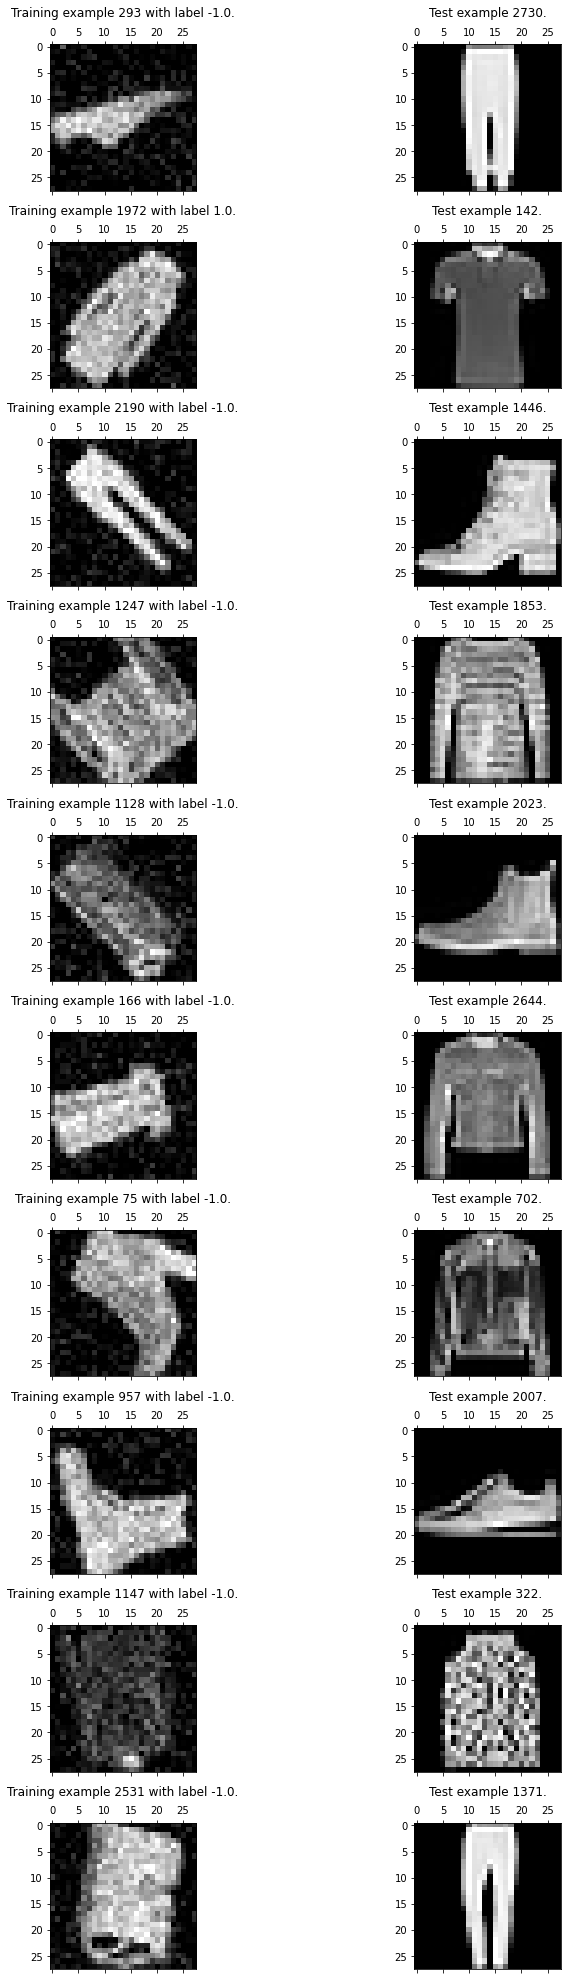

In [186]:
plt.gray()
fig, axs = plt.subplots(10,2, figsize=(30,30))
rand_select = np.round(rand(10, 2) * n_train, 0).astype(int)

for i, j in zip(range(10), rand_select):
  train_rand = j[0]
  test_rand = j[1]
  axs[i, 0].matshow(Xtrain[train_rand])
  axs[i, 0].set_title(f"Training example {train_rand} with label {Ytrain[train_rand]}.", pad=20)
  axs[i, 1].matshow(Xtest[test_rand])
  axs[i, 1].set_title(f"Test example {test_rand}.", pad=20)

fig.tight_layout(rect=[0, 0.03, 0.6, 0.95])

Accuracy out of the question as the training data are heavily skewed towards the negative class.